### Credits
https://www.kaggle.com/reiinakano/basic-nlp-bag-of-words-tf-idf-word2vec-lstm

https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering

https://github.com/beyondacm/Kaggle_Personalized_Medicine

https://stackoverflow.com/questions/37266341/plotting-a-python-dict-in-order-of-key-values

https://www.kaggle.com/therzv/implementing-labelencoder-and-onehotencoder

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from itertools import zip_longest
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from scipy import sparse
from sklearn.decomposition import TruncatedSVD
import nltk

### Loading data

In [2]:
data = pd.read_csv('training/training_variants')
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
# note the seprator in this file
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


### Merge text and values

In [4]:
df_train = pd.merge(data, data_text, how='left', on='ID')

In [5]:
df_train.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
df_train.shape

(3321, 5)

<h3>3.1.3. Preprocessing of text</h3>

In [7]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/karthikmgcp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [9]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 268.995276 seconds


In [10]:
#merging both gene_variations and text data based on ID
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [11]:
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [12]:
result.shape

(3321, 5)

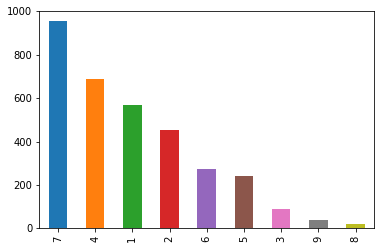

In [13]:
result['Class'].value_counts().plot(kind='bar')

## Random model

In [14]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

### Top words

In [15]:
all_words = []
for i in result['TEXT']:
    words = str(i).split()
    for i in words:
        g = i.isdigit()
        if not g:
            all_words.append(i)

In [16]:
len(all_words)

20546602

In [17]:
x = Counter(all_words)

In [18]:
import operator
sorted_x = sorted(x.items(), key=operator.itemgetter(1), reverse=True)

In [19]:
top_2k_words = []
for i in sorted_x[:2000]:
    top_2k_words.append(i[0])

In [20]:
len(top_2k_words)

2000

## First Feature engineering

Here we represented the text features by using both bag of words and tfidf vectorizations and reduced their feature space using truncated svd. We also added features like word_density, document length, Indicator feature depending on the length of the text

### Tfidf vectorization + svd on text

In [21]:
tfidfvectorizer = TfidfVectorizer(min_df=5, ngram_range=(1,3), max_features=50000, stop_words='english')
train_text_feature_tfidf = tfidfvectorizer.fit_transform(result['TEXT'].values.astype('U'))

In [22]:
train_text_feature_tfidf = normalize(train_text_feature_tfidf, axis=0)

In [23]:
print(train_text_feature_tfidf.shape)

(3321, 50000)


In [24]:
svd = TruncatedSVD(n_components=1000)
train_text_feature_tfidf_svd = svd.fit_transform(train_text_feature_tfidf)

In [25]:
len(train_text_feature_tfidf_svd)

3321

In [26]:
result.shape

(3321, 5)

In [27]:
train_text_feature_tfidf_svd.shape

(3321, 1000)

In [28]:
df_tfidf_col_name = ["tfidf_"+str(i) for i in range(1000)]
df_tfidf= pd.DataFrame(train_text_feature_tfidf_svd)
df_tfidf.columns = df_tfidf_col_name
df_tfidf.tail()

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
3316,0.048835,0.226168,-0.303845,-0.050618,-0.269677,-0.087591,-0.069472,-0.084134,0.014041,0.019114,...,-0.018785,-0.001215,-0.024713,0.009466,-0.018060,-0.006932,-0.008582,-0.013133,0.003655,0.003301
3317,0.028574,0.154918,-0.215939,-0.028083,-0.179527,-0.071755,-0.048534,-0.057453,-0.015495,0.028219,...,0.004158,0.007745,0.005362,-0.009487,-0.005980,-0.000808,0.008182,-0.002496,-0.003396,-0.012459
3318,0.022466,0.082302,-0.119403,-0.030798,-0.082061,-0.029632,-0.015867,-0.011370,-0.004770,0.003661,...,-0.007904,0.068449,-0.012044,-0.018054,0.018220,-0.001886,-0.008293,0.033811,-0.026123,-0.018239
3319,0.055895,0.223717,-0.282608,-0.069521,-0.207801,-0.058964,-0.019058,-0.026675,0.003955,0.030440,...,-0.006853,0.012886,-0.065838,-0.019376,-0.027723,-0.047035,0.045465,-0.041221,0.025130,-0.095623
3320,0.061440,0.240294,-0.310069,-0.065962,-0.236450,-0.054467,-0.030027,-0.043498,0.025211,0.035099,...,0.005717,0.004911,0.006352,0.014330,0.016624,0.002177,-0.007513,0.008455,-0.006823,0.011895


In [29]:
result = result.join(df_tfidf)

In [30]:
result.head()

,ID,Gene,Variation,Class,TEXT,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...,0.075418,0.339501,-0.445951,-0.093308,-0.399880,...,0.022684,-0.003189,-0.004960,0.015199,0.002778,-0.026710,0.009887,-0.021130,0.011547,0.009880
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,0.013063,-0.021587,-0.033221,-0.011368,-0.000452,-0.003446,0.004383,0.011537,-0.004643,0.007947
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,0.013063,-0.021587,-0.033221,-0.011368,-0.000452,-0.003446,0.004383,0.011537,-0.004643,0.007947
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.056787,0.261238,-0.371091,-0.078937,-0.308460,...,-0.000033,-0.004271,-0.004883,-0.021915,0.002449,-0.008118,0.007434,-0.004506,-0.004086,0.003750
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,0.090825,0.249616,-0.343288,-0.074384,-0.292224,...,-0.001192,0.002521,0.002351,0.001573,-0.002074,0.001158,-0.003148,-0.000294,0.001912,-0.005109


### Bow text feature + svd 

In [31]:
vectorizer = CountVectorizer(ngram_range=(1,1), min_df=5)
vectorizer.fit(result['TEXT'].values.astype('U'))

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [32]:
train_text_feature_bow = vectorizer.transform(result['TEXT'].values.astype('U'))

In [33]:
train_text_feature_bow.shape

(3321, 48695)

In [34]:
svd = TruncatedSVD(n_components = 1000)
train_text_feature_bow_svd = svd.fit_transform(train_text_feature_bow)

In [35]:
df_bow_col_name = ["bow_"+str(i) for i in range(1000)]
df_bow = pd.DataFrame(train_text_feature_bow_svd)
df_bow.columns = df_bow_col_name
df_bow.tail()

,bow_0,bow_1,bow_2,bow_3,bow_4,bow_5,bow_6,bow_7,bow_8,bow_9,...,bow_990,bow_991,bow_992,bow_993,bow_994,bow_995,bow_996,bow_997,bow_998,bow_999
3316,214.525440,-23.683861,-8.397137,18.521397,23.770978,-34.197317,-51.111674,25.345508,0.946733,4.110419,...,0.201849,-0.028120,1.350580,-0.085893,-0.381516,-1.573412,0.237064,1.193382,0.220588,0.899606
3317,106.386987,-35.351904,-18.813808,8.030367,25.875510,-27.482300,-21.141927,38.921030,-5.079902,5.141057,...,-0.428536,0.781640,0.195815,0.111233,0.640686,1.180329,-0.678516,-1.220558,-0.352163,-0.694912
3318,79.248475,-4.256188,8.875103,-5.262127,16.000510,-24.463799,-9.378032,13.782062,9.231528,21.731698,...,-0.037928,-2.353798,-0.768447,-0.756822,1.171650,-1.432714,-1.430498,-1.047122,-0.118805,0.114285
3319,107.161766,-1.321002,4.022593,-0.851773,0.405407,-11.161202,13.366140,-53.254765,30.249083,-10.905202,...,0.456764,2.919646,1.926457,1.001365,-0.304427,3.648754,-3.189715,3.211479,-0.757178,-2.949845
3320,201.531534,-3.757868,21.113571,11.663852,-7.572721,-14.555446,-19.786270,-75.921481,31.630264,-8.772630,...,-0.580012,1.870032,-1.575482,0.174261,-0.693239,0.813511,-0.804910,0.579334,0.112317,-0.193474


In [36]:
result = result.join(df_bow)

In [37]:
result.head()

,ID,Gene,Variation,Class,TEXT,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,...,bow_990,bow_991,bow_992,bow_993,bow_994,bow_995,bow_996,bow_997,bow_998,bow_999
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...,0.075418,0.339501,-0.445951,-0.093308,-0.399880,...,1.121746,-1.778654,4.392124,-2.993762,4.489056,-4.605156,-2.387844,-3.051298,5.445042,0.599752
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,1.777756,-1.205176,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,1.777756,-1.205176,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.056787,0.261238,-0.371091,-0.078937,-0.308460,...,1.018947,-1.209469,-0.012252,0.664811,-1.012342,0.005678,-1.193964,0.972015,-0.117319,1.295900
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,0.090825,0.249616,-0.343288,-0.074384,-0.292224,...,-0.241663,-0.172773,0.473699,0.184001,-0.845177,-0.270984,0.828808,0.031000,0.183417,-0.887934


### Word density feature

In [38]:
train_word_length=[]
for i in result['TEXT']:
    size = str(i).split()
    train_word_length.append(len(size))

In [39]:
train_letter_length = []
for i in result['TEXT']:
    train_letter_length.append(len(str(i)))

In [40]:
train_new_feature = []
for (x,y) in zip_longest(train_word_length, train_letter_length):
    train_new_feature.append(y/x)

In [41]:
result['word_density'] = train_new_feature

In [42]:
result.head()

,ID,Gene,Variation,Class,TEXT,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,...,bow_991,bow_992,bow_993,bow_994,bow_995,bow_996,bow_997,bow_998,bow_999,word_density
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...,0.075418,0.339501,-0.445951,-0.093308,-0.399880,...,-1.778654,4.392124,-2.993762,4.489056,-4.605156,-2.387844,-3.051298,5.445042,0.599752,7.056293
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,-1.205176,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544,6.727229
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,-1.205176,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544,6.727229
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.056787,0.261238,-0.371091,-0.078937,-0.308460,...,-1.209469,-0.012252,0.664811,-1.012342,0.005678,-1.193964,0.972015,-0.117319,1.295900,7.313981
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,0.090825,0.249616,-0.343288,-0.074384,-0.292224,...,-0.172773,0.473699,0.184001,-0.845177,-0.270984,0.828808,0.031000,0.183417,-0.887934,7.439821


### word count feature

In [43]:
totallist = []
for i in result['TEXT']:
    words = str(i).split()
    totallist.append(len(words))

In [44]:
len(totallist)

3321

In [45]:
result['word_length'] = totallist

In [46]:
result.head()

,ID,Gene,Variation,Class,TEXT,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,...,bow_992,bow_993,bow_994,bow_995,bow_996,bow_997,bow_998,bow_999,word_density,word_length
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...,0.075418,0.339501,-0.445951,-0.093308,-0.399880,...,4.392124,-2.993762,4.489056,-4.605156,-2.387844,-3.051298,5.445042,0.599752,7.056293,4370
1,1,CBL,W802*,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544,6.727229,4139
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...,0.056765,0.310050,-0.446154,-0.125913,-0.346026,...,-1.883669,-0.641438,2.608033,1.119233,-2.628410,1.702041,-1.789849,-0.858544,6.727229,4139
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...,0.056787,0.261238,-0.371091,-0.078937,-0.308460,...,-0.012252,0.664811,-1.012342,0.005678,-1.193964,0.972015,-0.117319,1.295900,7.313981,3841
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...,0.090825,0.249616,-0.343288,-0.074384,-0.292224,...,0.473699,0.184001,-0.845177,-0.270984,0.828808,0.031000,0.183417,-0.887934,7.439821,4254


### Indicator feature

In [47]:
totallist = []
for i in result['TEXT']:
    words = str(i).split()
    if len(words) < 2000:
        totallist.append(1)
    else:
        totallist.append(0)

In [48]:
len(totallist)

3321

In [49]:
result['indicator_feature'] = totallist

In [50]:
result.shape

(3321, 2008)

In [51]:
result.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'TEXT', 'tfidf_0', 'tfidf_1',
       'tfidf_2', 'tfidf_3', 'tfidf_4',
       ...
       'bow_993', 'bow_994', 'bow_995', 'bow_996', 'bow_997', 'bow_998',
       'bow_999', 'word_density', 'word_length', 'indicator_feature'],
      dtype='object', length=2008)

In [52]:
result1 = result.drop(['Gene','Variation','TEXT'],axis=1)

In [53]:
result1.shape

(3321, 2005)

In [54]:
y_true = result1['Class'].values
# result.Gene      = result.Gene.str.replace('\s+', '_')
# result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result1, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

for alpha = 1e-06
Log Loss : 1.8268570986710921
for alpha = 1e-05
Log Loss : 1.8268570986711459
for alpha = 0.0001
Log Loss : 1.826857098671086
for alpha = 0.001
Log Loss : 1.8268570986710688
for alpha = 0.01
Log Loss : 1.7543705696040455
for alpha = 0.1
Log Loss : 1.7367308335525444
for alpha = 1
Log Loss : 1.714797784111537
for alpha = 10
Log Loss : 1.7432183905583234
for alpha = 100
Log Loss : 1.7133367310278544


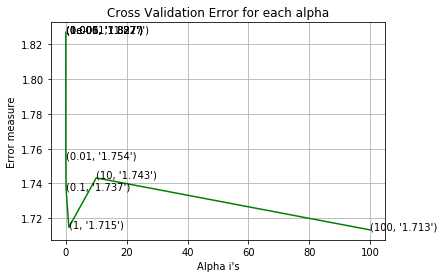

For values of best alpha =  100 The train log loss is: 1.6862503428979592
For values of best alpha =  100 The cross validation log loss is: 1.7133367310278544
For values of best alpha =  100 The test log loss is: 1.6999618683442603


In [55]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [22]:
x = PrettyTable()

In [23]:
x.field_names = (['Featurizations', 'models', 'test_loss', 'cv_loss'])

In [24]:
x.add_row(['tfidf and bow of text + doc len + word_density + indicator variable', 'logisitic regression', 1.69, 1.71])

In [25]:
print(x)

+---------------------------------------------------------------------+----------------------+-----------+---------+
|                            Featurizations                           |        models        | test_loss | cv_loss |
+---------------------------------------------------------------------+----------------------+-----------+---------+
| tfidf and bow of text + doc len + word_density + indicator variable | logisitic regression |    1.69   |   1.71  |
+---------------------------------------------------------------------+----------------------+-----------+---------+


Model performed poorly with log loss on cross validation and testing being high.

## Second feature engineering try 

I got part of this featurization from a kaggle kernel. Not to copy the same featurizations, I made added some more feature as an experiment and this turned out well!!!

Here we will combine onehotEncoded and LabelEncoded feature of the both gene and variation feature and also add in the word_density feature

In [56]:
gene_dummy = pd.get_dummies(result['Gene'])

In [57]:
gene_dummy.shape

(3321, 264)

In [58]:
variation_dummy = pd.get_dummies(result['Variation'])

In [59]:
variation_dummy.shape

(3321, 2996)

In [60]:
dummy_df = pd.concat([gene_dummy, variation_dummy], axis=1)

In [61]:
dummy_df['Class'] = result['Class']

In [62]:
dummy_df.head()

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B_Fusion,YAP1-MAMLD1_Fusion,ZC3H7B-BCOR_Fusion,ZNF198-FGFR1_Fusion,p61BRAF,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [63]:
dummy_df.head()

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B_Fusion,YAP1-MAMLD1_Fusion,ZC3H7B-BCOR_Fusion,ZNF198-FGFR1_Fusion,p61BRAF,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


### combining features

In [64]:
y_true = dummy_df['Class'].values
# result.Gene      = result.Gene.str.replace('\s+', '_')
# result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(dummy_df, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

### Label encoded features

In [71]:
from sklearn.preprocessing import LabelEncoder

In [72]:
le = LabelEncoder()

In [73]:
le_X = dummy_df.apply(le.fit_transform)

In [74]:
le_X.head()

,ABL1,ACVR1,AGO2,AKT1,AKT2,AKT3,ALK,APC,AR,ARAF,...,Y901C,Y931C,Y98H,Y98N,YAP1-FAM118B_Fusion,YAP1-MAMLD1_Fusion,ZC3H7B-BCOR_Fusion,ZNF198-FGFR1_Fusion,p61BRAF,Class
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [75]:
result.shape

(3321, 2008)

In [76]:
le_Y = result['Class']

In [77]:
y_true = result['Class'].values
# result.Gene      = result.Gene.str.replace('\s+', '_')
# result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(le_X, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

### ADDING IN WORD DENSITY FEATURE

In [78]:
density_df = pd.DataFrame(train_new_feature, columns=['word_density'])

### merging dummies and label encoding

In [79]:
dummy_label_df = pd.concat([dummy_df, le_X, density_df], axis=1)

In [80]:
dummy_label_df['Class'] = result['Class']

In [81]:
dummy_label_df.shape

(3321, 6523)

In [82]:
y_true = result['Class'].values
# result.Gene      = result.Gene.str.replace('\s+', '_')
# result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(dummy_label_df, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [83]:
X_train.shape

(2656, 6523)

### Dont run

In [178]:
# train_gene_var_tfidf = hstack((gene_dummy_sparse,variation_dummy_sparse))
# # test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_variation_feature_tfidf))
# cv_gene_var_tfidf = hstack((cvgene_dummy_sparse,cvvariation_dummy_sparse))

# train_x_onehotCoding = hstack((train_gene_var_tfidf, train_text_tfidf_bow)).tocsr()
# # train_x_onehotCoding = hstack((train_x_onehotCoding, train_text_feature_bow))
# train_y = np.array(list(train_df['Class']))

# # test_x_onehotCoding = hstack((test_gene_var_tfidf, test_text_tfidf_bow)).tocsr()
# # test_x_onehotCoding = hstack((test_x_onehotCoding, test_text_feature_bow))
# test_y = np.array(list(test_df['Class']))

# cv_x_onehotCoding = hstack((cv_gene_var_tfidf, cv_text_tfidf_bow)).tocsr()
# # cv_x_onehotCoding = hstack((cv_x_onehotCoding, cv_text_feature_bow))
# cv_y = np.array(list(cv_df['Class']))

In [ ]:
# print("One hot encoding features :")
# print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
# # print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
# print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

### machine learning model

In [84]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [85]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

## Naive bayes

for alpha = 1e-05
Log Loss : 1.0247001665455509
for alpha = 0.0001
Log Loss : 1.021686172590304
for alpha = 0.001
Log Loss : 0.9983226804636588
for alpha = 0.1
Log Loss : 0.8548202673966119
for alpha = 1
Log Loss : 1.30359075042839
for alpha = 10
Log Loss : 1.3654006019729208
for alpha = 100
Log Loss : 1.1718344352137167
for alpha = 1000
Log Loss : 1.0572639880629353


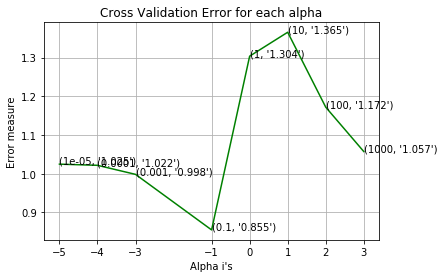

For values of best alpha =  0.1 The train log loss is: 0.3817674672011247
For values of best alpha =  0.1 The cross validation log loss is: 0.8548202673966119
For values of best alpha =  0.1 The test log loss is: 0.7613460995300819


In [86]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)


predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

## Knn

for alpha = 5
Log Loss : 0.17697304857465673
for alpha = 11
Log Loss : 0.14054083385567706
for alpha = 15
Log Loss : 0.12824009641126455
for alpha = 21
Log Loss : 0.11051770619715222
for alpha = 31
Log Loss : 0.08826680132464819
for alpha = 41
Log Loss : 0.08067117267226676
for alpha = 51
Log Loss : 0.0735918952024841
for alpha = 99
Log Loss : 0.037500970933175955


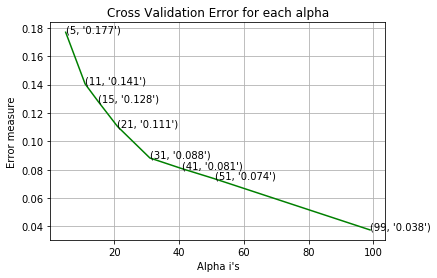

For values of best alpha =  99 The train log loss is: 0.038022824977746214
For values of best alpha =  99 The cross validation log loss is: 0.037500970933175955
For values of best alpha =  99 The test log loss is: 0.03473444005780409


In [87]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


### Logisitic regression with class balancing

for alpha = 1e-06
Log Loss : 0.6272498737026784
for alpha = 1e-05
Log Loss : 0.6141217983138775
for alpha = 0.0001
Log Loss : 0.6076303467306531
for alpha = 0.001
Log Loss : 0.5931328394979757
for alpha = 0.01
Log Loss : 0.6428121862319637
for alpha = 0.1
Log Loss : 0.8173403690485482
for alpha = 1
Log Loss : 0.9364885317872759
for alpha = 10
Log Loss : 1.1464798770946145
for alpha = 100
Log Loss : 0.9729593042949972


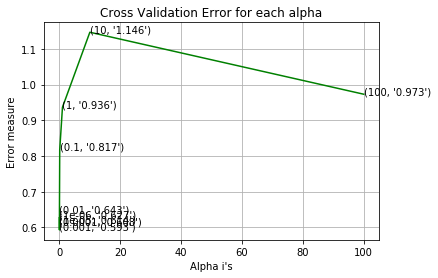

For values of best alpha =  0.001 The train log loss is: 0.49896494835453115
For values of best alpha =  0.001 The cross validation log loss is: 0.5931328394979757
For values of best alpha =  0.001 The test log loss is: 0.5606730521012762


In [88]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Logisitic regression without class balancing

for alpha = 1e-06
Log Loss : 0.6267762942557226
for alpha = 1e-05
Log Loss : 0.6168584943083493
for alpha = 0.0001
Log Loss : 0.6158290114283193
for alpha = 0.001
Log Loss : 0.6030762966604213
for alpha = 0.01
Log Loss : 0.6445599318975649
for alpha = 0.1
Log Loss : 0.8528088145559871
for alpha = 1
Log Loss : 0.9471386747354591
for alpha = 10
Log Loss : 0.9484605371338213
for alpha = 100
Log Loss : 1.1029144618871263


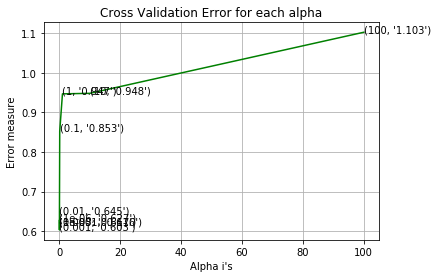

For values of best alpha =  0.001 The train log loss is: 0.49896494835453115
For values of best alpha =  0.001 The cross validation log loss is: 0.5931328394979757
For values of best alpha =  0.001 The test log loss is: 0.5606730521012762


In [89]:
# label encoded + one hot encoded features
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Linear SVC

for C = 1e-05
Log Loss : 0.57863003652586
for C = 0.0001
Log Loss : 0.5270564589796367
for C = 0.001
Log Loss : 0.5281671656398833
for C = 0.01
Log Loss : 0.5720529801907454
for C = 0.1
Log Loss : 0.5979852948597111
for C = 1
Log Loss : 0.6246188545320084
for C = 10
Log Loss : 0.9057708995266169
for C = 100
Log Loss : 0.9068787067275329


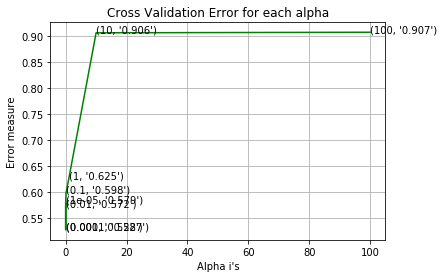

For values of best alpha =  0.0001 The train log loss is: 0.3859234272204214
For values of best alpha =  0.0001 The cross validation log loss is: 0.5270564589796367
For values of best alpha =  0.0001 The test log loss is: 0.5557261273766145


In [119]:
#label encoded features + onehot features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Random forest classifiers

In [120]:
# onehot + label encoded
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_df, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_df, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_df)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.0215260157369912
for n_estimators = 100 and max depth =  10
Log Loss : 0.9029758174220439
for n_estimators = 200 and max depth =  5
Log Loss : 1.021098108349095
for n_estimators = 200 and max depth =  10
Log Loss : 0.8916237088271247
for n_estimators = 500 and max depth =  5
Log Loss : 0.903357546304222
for n_estimators = 500 and max depth =  10
Log Loss : 0.8267483930630186
for n_estimators = 1000 and max depth =  5
Log Loss : 0.8955893469355333
for n_estimators = 1000 and max depth =  10
Log Loss : 0.8145736637309244
for n_estimators = 2000 and max depth =  5
Log Loss : 0.9017948987742215
for n_estimators = 2000 and max depth =  10
Log Loss : 0.8177650231013055
For values of best estimator =  1000 The train log loss is: 0.6145987457574293
For values of best estimator =  1000 The cross validation log loss is: 0.8145736637309244
For values of best estimator =  1000 The test log loss is: 0.8123476491397051


### Stacking classifiers

In [121]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_df, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_df, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_df, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_df, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_df))))
sig_clf2.fit(train_df, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_df))))
sig_clf3.fit(train_df, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_df))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_df, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_df))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_df))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 0.52
Support vector machines : Log Loss: 0.59
Naive Bayes : Log Loss: 1.13
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.167
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.941
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.176
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 0.589
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 0.451
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 0.555


### Voting classifier

In [122]:
# label+onehot
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_df, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_df)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_df)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_df)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_df)- y_test))/y_test.shape[0])
# plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.4786653097594269
Log loss (CV) on the VotingClassifier : 0.6799274897471931
Log loss (test) on the VotingClassifier : 0.7033444079398297
Number of missclassified point : 0.16090225563909774


## third feature engineering try

### Using label encoded features

for alpha = 1e-06
Log Loss : 1.1997155138536153
for alpha = 1e-05
Log Loss : 1.1548663681681723
for alpha = 0.0001
Log Loss : 1.0937084686002612
for alpha = 0.001
Log Loss : 1.1298118085751438
for alpha = 0.01
Log Loss : 1.2341629368722815
for alpha = 0.1
Log Loss : 1.2683100548334774
for alpha = 1
Log Loss : 1.2562890792159038
for alpha = 10
Log Loss : 1.340396029814389
for alpha = 100
Log Loss : 1.3764630324207412


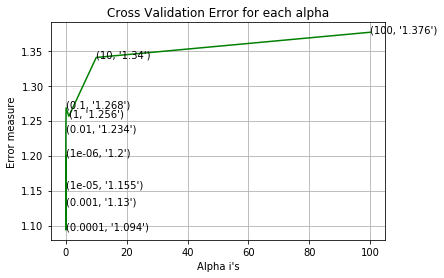

For values of best alpha =  0.0001 The train log loss is: 0.5477646546755032
For values of best alpha =  0.0001 The cross validation log loss is: 1.0937084686002612
For values of best alpha =  0.0001 The test log loss is: 1.1458285538527955


In [101]:
#Only on label encoded features
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [105]:
# label encoded
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_df, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_df, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_df)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

'''fig, ax = plt.subplots()
features = np.dot(np.array(alpha)[:,None],np.array(max_depth)[None]).ravel()
ax.plot(features, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[int(i/2)],max_depth[int(i%2)],str(txt)), (features[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()
'''

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.2566048597712296
for n_estimators = 100 and max depth =  10
Log Loss : 1.2267890242484218
for n_estimators = 200 and max depth =  5
Log Loss : 1.2348384446947789
for n_estimators = 200 and max depth =  10
Log Loss : 1.2173029857900781
for n_estimators = 500 and max depth =  5
Log Loss : 1.225410206115976
for n_estimators = 500 and max depth =  10
Log Loss : 1.2149803215701074
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2210590245781132
for n_estimators = 1000 and max depth =  10
Log Loss : 1.211726448584069
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2165227109499483
for n_estimators = 2000 and max depth =  10
Log Loss : 1.209793265853651
For values of best estimator =  2000 The train log loss is: 0.9585066923155573
For values of best estimator =  2000 The cross validation log loss is: 1.209793265853651
For values of best estimator =  2000 The test log loss is: 1.2461461847474957


for C = 1e-05
Log Loss : 1.1636575257892572
for C = 0.0001
Log Loss : 1.1544002767632975
for C = 0.001
Log Loss : 1.2032701168662554
for C = 0.01
Log Loss : 1.330167381859787
for C = 0.1
Log Loss : 1.3285713219890012
for C = 1
Log Loss : 1.3330819371534532
for C = 10
Log Loss : 1.3094056893072625
for C = 100
Log Loss : 1.4034369624555583


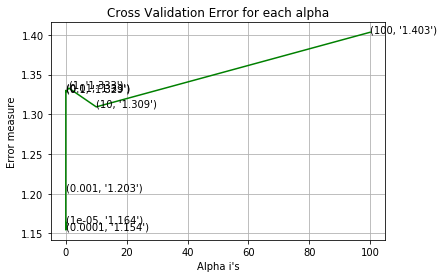

For values of best alpha =  0.0001 The train log loss is: 0.5607917896176803
For values of best alpha =  0.0001 The cross validation log loss is: 1.1544002767632975
For values of best alpha =  0.0001 The test log loss is: 1.2083015390547496


In [104]:
#Only on label encoded features
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.1695411651324965
for alpha = 1e-05
Log Loss : 1.1475214194598464
for alpha = 0.0001
Log Loss : 1.0941258902938995
for alpha = 0.001
Log Loss : 1.1176000558715717
for alpha = 0.01
Log Loss : 1.2192138160640202
for alpha = 0.1
Log Loss : 1.2624259920488718
for alpha = 1
Log Loss : 1.2573798694910623
for alpha = 10
Log Loss : 1.3230751564746421
for alpha = 100
Log Loss : 1.3676508174871012


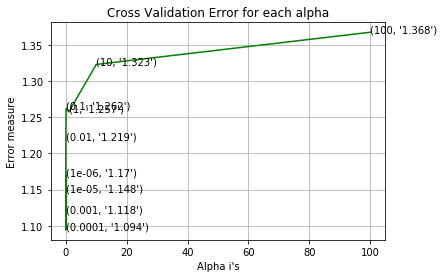

For values of best alpha =  0.0001 The train log loss is: 0.5477646546755032
For values of best alpha =  0.0001 The cross validation log loss is: 1.0937084686002612
For values of best alpha =  0.0001 The test log loss is: 1.1458285538527955


In [102]:
#Only on label encoded features
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_df, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_df, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_df)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_df, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_df, y_train)

predict_y = sig_clf.predict_proba(train_df)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_df)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

In [106]:
# only label encoding
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_df, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_df, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_df, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_df, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_df))))
sig_clf2.fit(train_df, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_df))))
sig_clf3.fit(train_df, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_df))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_df, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_df))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_df))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.13
Support vector machines : Log Loss: 1.33
Naive Bayes : Log Loss: 1.23
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 2.179
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 2.045
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.564
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.161
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.180
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.413


In [108]:
# only label encoding
#Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_df, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_df)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_df)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_df)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_df)- y_test))/y_test.shape[0])
# plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))

Log loss (train) on the VotingClassifier : 0.7586164538619627
Log loss (CV) on the VotingClassifier : 1.2058377579359651
Log loss (test) on the VotingClassifier : 1.2430735345812962
Number of missclassified point : 0.42857142857142855


All the models performed very well with these features.

## Results

In [1]:
from prettytable import PrettyTable

In [2]:
x = PrettyTable()

In [3]:
x.field_names = (['Featurizations', 'models', 'test_loss', 'cv_loss'])

In [12]:
x.add_row([' ', 'VOTING CLASSIFIER', 0.70, 0.67])

In [13]:
print(x)

+-------------------------------------------------------------------------------+--------------------------+-----------+---------+
|                                 Featurizations                                |          models          | test_loss | cv_loss |
+-------------------------------------------------------------------------------+--------------------------+-----------+---------+
| LABEL ENCODING + ONEHOT ENCODING ON GENE AND VARIATION + word_density feature |            NB            |    0.76   |   0.85  |
|                                                                               |           KNN            |    0.03   |   0.03  |
|                                                                               |  LOGREG WITH CLASS BAL   |    0.56   |   0.59  |
|                                                                               | LOGREG WITHOUT CLASS BAL |    0.56   |   0.59  |
|                                                                               |  

### Third Feature Engineering

In [108]:
import nltk
from nltk import FreqDist

In [277]:
for i in train_df['TEXT']:
    tokenizer = nltk.word_tokenize(i)
    x = nltk.FreqDist(tokenizer)

In [164]:
most_freq_words = list(x.keys())

In [306]:
variation_vectorizer = TfidfVectorizer(stop_words='english')
variation_vectorizer.fit(most_freq_words)
train_text_feature_bow = variation_vectorizer.transform(train_df['TEXT'])
test_text_feature_bow = variation_vectorizer.transform(test_df['TEXT'])
cv_text_feature_bow = variation_vectorizer.transform(cv_df['TEXT'])

train_y = np.array(list(train_df['Class']))
test_y = np.array(list(test_df['Class']))
cv_y = np.array(list(cv_df['Class']))

In [307]:
# don't forget to normalize every feature
train_text_feature_bow = normalize(train_text_feature_bow, axis=0)
test_text_feature_bow = normalize(test_text_feature_bow, axis=0)
cv_text_feature_bow = normalize(cv_text_feature_bow, axis=0)

In [315]:
train_text_feature_bow.shape

(2124, 1230)

### first new feature

In [308]:
train_word_length=[]
for i in train_df['TEXT']:
    size = i.split()
    train_word_length.append(len(size))

test_word_length=[]
for i in test_df['TEXT']:
    size = i.split()
    test_word_length.append(len(size))

cv_word_length=[]
for i in cv_df['TEXT']:
    size = i.split()
    cv_word_length.append(len(size))

In [309]:
train_letter_length = []
for i in train_df['TEXT']:
    train_letter_length.append(len(i))
    
test_letter_length = []
for i in test_df['TEXT']:
    test_letter_length.append(len(i))
    
cv_letter_length = []
for i in cv_df['TEXT']:
    cv_letter_length.append(len(i))

In [287]:
from itertools import zip_longest

In [310]:
train_new_feature = []
for (x,y) in zip_longest(train_word_length, train_letter_length):
    train_new_feature.append(y/x)

test_new_feature = []
for x,y in zip_longest(test_word_length, test_letter_length):
    test_new_feature.append((y/x))

cv_new_feature = []
for x,y in zip_longest(cv_word_length, cv_letter_length):
    cv_new_feature.append((y/x))

In [290]:
from scipy import sparse

In [311]:
train_new_feature = sparse.csr_matrix(train_new_feature)
test_new_feature = sparse.csr_matrix(test_new_feature)
cv_new_feature = sparse.csr_matrix(cv_new_feature)

In [312]:
train_new_feature.shape

(1, 2124)

In [313]:
train_new_feature = train_new_feature.reshape(-1,1)
test_new_feature = test_new_feature.reshape(-1,1)
cv_new_feature = cv_new_feature.reshape(-1,1)

### second new feature

## Length of text feature

In [348]:
train_length = []
for i in train_df['TEXT']:
    train_length.append(len(i))

In [349]:
test_length = []
for i in test_df['TEXT']:
    test_length.append(len(i))

In [350]:
cv_length = []
for i in cv_df['TEXT']:
    cv_length.append(len(i))

In [351]:
train_len = np.asarray(train_length)
test_len = np.asarray(test_length)
cv_len = np.asarray(cv_length)

In [352]:
train_len = train_len.reshape(-1,1)

In [353]:
test_len = test_len.reshape(-1,1)

In [354]:
cv_len = cv_len.reshape(-1,1)

In [355]:
(train_len).shape

(2124, 1)

In [334]:
train_gene_var_tfidf = hstack((train_gene_feature_tfidf,train_variation_feature_tfidf))
test_gene_var_tfidf = hstack((test_gene_feature_tfidf,test_variation_feature_tfidf))
cv_gene_var_tfidf = hstack((cv_gene_feature_tfidf,cv_variation_feature_tfidf))

train_x_onehotCoding = hstack((train_gene_var_tfidf, train_text_feature_bow))
train_x_onehotCoding = hstack((train_x_onehotCoding, train_new_feature)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_tfidf, test_text_feature_bow))
test_x_onehotCoding = hstack((test_x_onehotCoding, test_new_feature)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_tfidf, cv_text_feature_bow))
cv_x_onehotCoding = hstack((cv_x_onehotCoding, cv_new_feature)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [335]:
train_x_onehotCoding.shape

(2124, 3438)

In [319]:
test_x_onehotCoding.shape

(665, 3438)

In [320]:
cv_x_onehotCoding.shape

(532, 3438)

### Truncatedsvd

In [254]:
from sklearn.decomposition import TruncatedSVD

In [338]:
svd = TruncatedSVD(n_components=1500)

In [339]:
train_x_onehotCoding = svd.fit_transform(train_x_onehotCoding)
test_x_onehotCoding = svd.transform(test_x_onehotCoding)
cv_x_onehotCoding = svd.transform(cv_x_onehotCoding)

### logreg

for alpha = 1e-06
Log Loss : 1.0647382042713576
for alpha = 1e-05
Log Loss : 1.0675105254903456
for alpha = 0.0001
Log Loss : 1.0559712136999804
for alpha = 0.001
Log Loss : 1.0563767610258168
for alpha = 0.01
Log Loss : 1.159928037676655
for alpha = 0.1
Log Loss : 1.4313116454619872
for alpha = 1
Log Loss : 1.8114198975654126
for alpha = 10
Log Loss : 1.8205908076021138
for alpha = 100
Log Loss : 1.8206580971150146


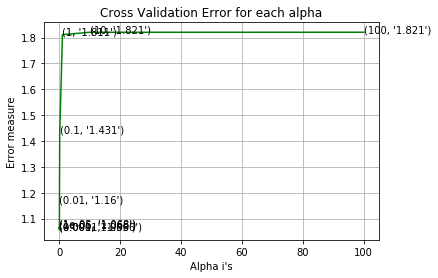

For values of best alpha =  0.0001 The train log loss is: 0.8921910467010907
For values of best alpha =  0.0001 The cross validation log loss is: 1.0559712136999804
For values of best alpha =  0.0001 The test log loss is: 1.0825115519058393


In [340]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### knn

for alpha = 5
Log Loss : 1.1018427591499609
for alpha = 11
Log Loss : 1.1472326436315776
for alpha = 15
Log Loss : 1.1759286772900859
for alpha = 21
Log Loss : 1.1987688886259151
for alpha = 31
Log Loss : 1.2298698343909968
for alpha = 41
Log Loss : 1.2668791690933328
for alpha = 51
Log Loss : 1.2984045728327516
for alpha = 99
Log Loss : 1.3470198887238185


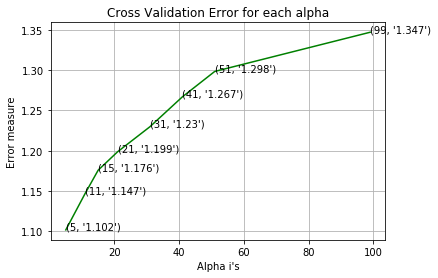

For values of best alpha =  5 The train log loss is: 0.8976199287403714
For values of best alpha =  5 The cross validation log loss is: 1.1018427591499609
For values of best alpha =  5 The test log loss is: 1.1408982388470772


In [356]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


In [ ]:
### knn

alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-06
Log Loss : 1.048203681367188
for alpha = 1e-05
Log Loss : 1.0372905570263757
for alpha = 0.0001
Log Loss : 0.9949612298843302
for alpha = 0.001
Log Loss : 1.0190016717667048
for alpha = 0.01
Log Loss : 1.1616103618265665
for alpha = 0.1
Log Loss : 1.218565711059477
for alpha = 1
Log Loss : 1.3150980514782513
for alpha = 10
Log Loss : 1.4108969057129972
for alpha = 100
Log Loss : 1.5629362822021642


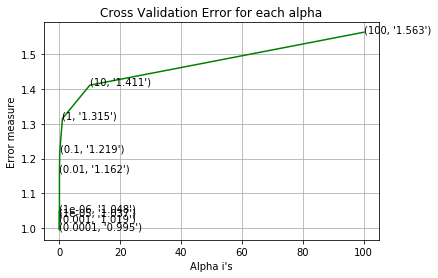

For values of best alpha =  0.0001 The train log loss is: 0.535344682823672
For values of best alpha =  0.0001 The cross validation log loss is: 0.9949612298843302
For values of best alpha =  0.0001 The test log loss is: 1.0054157350291917


In [149]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### training with new feature along with svd 2000 features

for alpha = 1e-06
Log Loss : 1.0726896896828928
for alpha = 1e-05
Log Loss : 1.0679183466595281
for alpha = 0.0001
Log Loss : 0.9996474691978341
for alpha = 0.001
Log Loss : 1.0067750223680827
for alpha = 0.01
Log Loss : 1.1317737005113406
for alpha = 0.1
Log Loss : 1.1835806413028613
for alpha = 1
Log Loss : 1.3081274853934068
for alpha = 10
Log Loss : 1.4173630478157766
for alpha = 100
Log Loss : 1.475355008422081


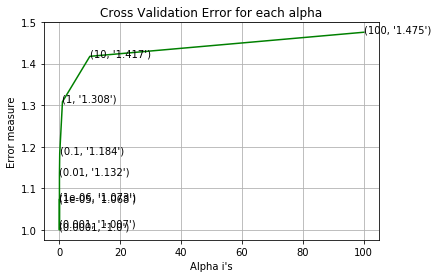

For values of best alpha =  0.0001 The train log loss is: 0.5197494446715658
For values of best alpha =  0.0001 The cross validation log loss is: 0.9996474691978341
For values of best alpha =  0.0001 The test log loss is: 1.025499760153781


In [802]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

This feature also performed nominally. It was able to bring cross validation losses to less than 1.0 at times which is appreciable